# Trying to stabilize the background of the video

In [1]:
# calculate optical flow of a video and try to stabilize other video with it 
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

Function to calculate the optical flow between frames

In [3]:
# calculate optical flow across frames in cropped/
def calculate_optical_flow(prev_frame, next_frame):
    # convert to grayscale
    prev_frame_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)
    next_frame_gray = cv.cvtColor(next_frame, cv.COLOR_BGR2GRAY)

    # calculate optical flow
    flow = cv.calcOpticalFlowFarneback(prev_frame_gray, next_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    return flow

Getting the next frame based on the previous frame + optical flow

In [4]:
def apply_optical_flow(frame, flow):
    h, w = flow.shape[:2]
    flow_map = np.stack(np.meshgrid(np.arange(w), np.arange(h)), -1).astype(np.float32) + flow
    warped_frame = cv.remap(frame, flow_map[..., 0].astype(np.float32), flow_map[..., 1].astype(np.float32), cv.INTER_LINEAR)
    return warped_frame

Loading original frames

In [5]:
# load frames in sorted order
frame_names = sorted(os.listdir('cropped/'))
frames = [cv.imread('cropped/' + frame_name) for frame_name in frame_names]

Calculating the optical flow

In [6]:
optical_flows = []
for i in range(len(frames) - 1):
    flow = calculate_optical_flow(frames[i], frames[i + 1])
    optical_flows.append(flow)    

Read the styled frames

In [39]:
# read new frames
# remove png, add jpg
styled_frames = [cv.imread('output/' + frame_name[:-3] + 'jpg') for frame_name in frame_names]

based on the histogram, if the shot changes, optical flow is pretty high, in that case, it is best to stick with the original frame
otherwise, use the last frame to get the next frame

In [22]:
overall_difference = []
for i in tqdm(range(len(styled_frames) - 1)):
    # check for shot changes
    # overall_difference.append(np.sum(np.abs(optical_flows[i])))
    if np.sum(np.abs(optical_flows[i])) < 200000:
        styled_frames[i + 1] = apply_optical_flow(styled_frames[i], optical_flows[i])
    # styled_frames[i + 1] = apply_optical_flow(styled_frames[i], optical_flows[i])

100%|██████████| 644/644 [00:00<00:00, 648.30it/s]


This is the graph that shows the sum of the optical flow across the frames

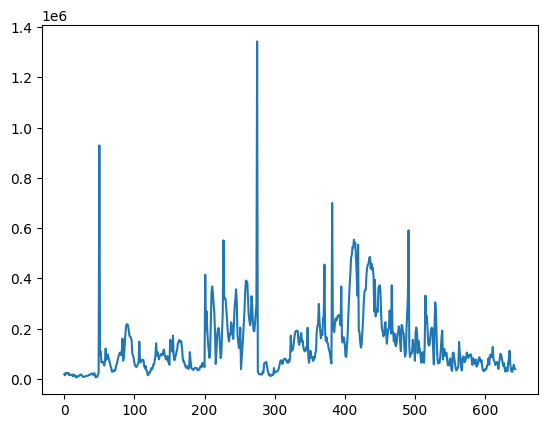

In [11]:
# plot as a graph
plt.plot(overall_difference)

Some images become warped as the optical flow of the foreground is too high

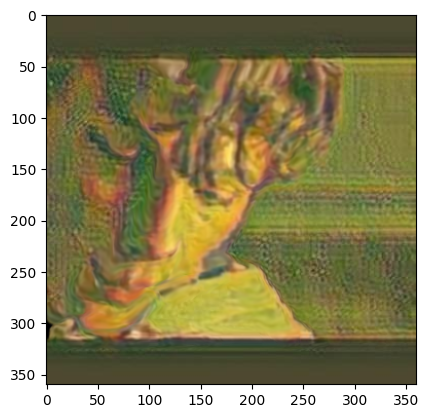

In [23]:
# plot an image
# change color space
plt.imshow(cv.cvtColor(styled_frames[500], cv.COLOR_BGR2RGB))

In [24]:
# dump into folder named stabilized
os.makedirs('stabilized', exist_ok=True)
for i, frame in enumerate(styled_frames):
    cv.imwrite('stabilized/' + frame_names[i], frame)

Trying to just stabilize the background

In [72]:
# read new frames
# remove png, add jpg
styled_frames = [cv.imread('output/' + frame_name[:-3] + 'jpg') for frame_name in frame_names]
styled_frames_new = [cv.imread('output/' + frame_name[:-3] + 'jpg') for frame_name in frame_names]

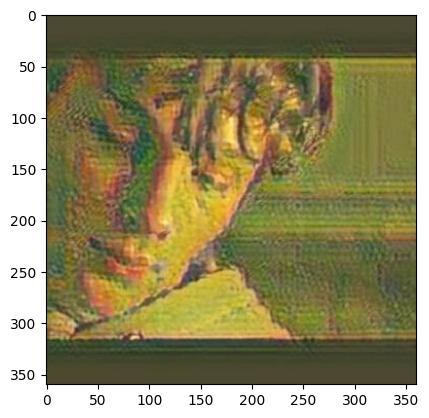

In [44]:
# plot an image
# change color space
plt.imshow(cv.cvtColor(styled_frames[500], cv.COLOR_BGR2RGB))

In [73]:
overall_difference = []
for i in tqdm(range(len(styled_frames) - 1)):
    # print the max and min abs value (both x and y) of the flow
    # for each pixel, if the value of the optical flow is more than 5, use the original frames pixel, otherwise use the old one + optical flow
    # if shot change, use the original frame
    if np.sum(np.abs(optical_flows[i])) < 300000:
        # styled_frames[i + 1] = apply_optical_flow(styled_frames[i], optical_flows[i])
        abs_optical_flow = np.abs(optical_flows[i])
        optical_flowed = apply_optical_flow(styled_frames[i], optical_flows[i])
        # get the max abs between x and y and merge them into one
        optical_flow_merged = np.max(abs_optical_flow, axis=2)
        # stack the optical flow to 3 channels
        optical_flow_merged = np.stack([optical_flow_merged] * 3, axis=2)
        styled_frames[i + 1] = np.where(optical_flow_merged > 0.1, styled_frames[i + 1], optical_flowed)


100%|██████████| 644/644 [00:04<00:00, 142.21it/s]


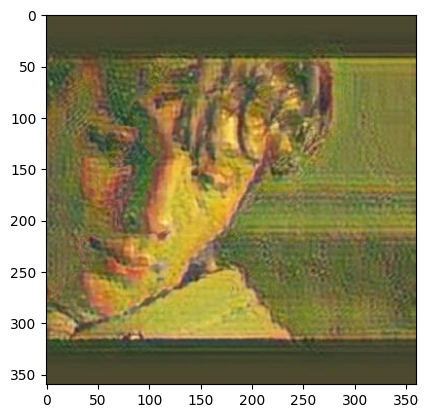

In [70]:
# plot an image
# change color space
plt.imshow(cv.cvtColor(styled_frames[500], cv.COLOR_BGR2RGB))

In [74]:
# dump into folder named stabilized
os.makedirs('background', exist_ok=True)
for i, frame in enumerate(styled_frames):
    cv.imwrite('background/' + frame_names[i], frame)

In [14]:
# read new frames
# remove png, add jpg
styled_frames = [cv.imread('output/' + frame_name[:-3] + 'jpg') for frame_name in frame_names]

In [13]:
overall_difference = []
for i in tqdm(range(len(styled_frames) - 1)):
    # print the max and min abs value (both x and y) of the flow
    # for each pixel, if the value of the optical flow is more than 5, use the original frames pixel, otherwise use the old one + optical flow
    # if shot change, use the original frame
    if np.sum(np.abs(optical_flows[i])) < 200000:
        # styled_frames[i + 1] = apply_optical_flow(styled_frames[i], optical_flows[i])
        abs_optical_flow = np.abs(optical_flows[i])
        optical_flowed = apply_optical_flow(styled_frames[i], optical_flows[i])
        # get the max abs between x and y and merge them into one
        optical_flow_merged = np.max(abs_optical_flow, axis=2)
        # stack the optical flow to 3 channels
        optical_flow_merged = np.stack([optical_flow_merged] * 3, axis=2)
        styled_frames[i + 1] = np.where(optical_flow_merged > 0.5, styled_frames[i + 1], optical_flowed)


100%|██████████| 644/644 [00:04<00:00, 160.66it/s]


In [12]:
# dump into folder
# dump into folder named stabilized
os.makedirs('pointilism', exist_ok=True)
for i, frame in enumerate(styled_frames):
    cv.imwrite('pointilism/' + frame_names[i], frame)